# **Предсказание оттока пользователей (Stacking + pipline)**

***Задача***: построить классификационные модели для пресказания оттока пользователей \
***Профиль на Kaggle***: https://www.kaggle.com/konstantinriabov \
***Страница соревнования***: https://www.kaggle.com/c/advanced-dls-spring-2021/overview \
**Результат:** 5 место.

**Импорт библиотек**

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

## **Анализ данных**

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Kaggle/Data/Предсказание оттока пользователей (весна 2021)/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Kaggle/Data/Предсказание оттока пользователей (весна 2021)/test.csv')
df_train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [ ]:
print(df_train.shape)
print(df_test.shape)

(5282, 20)
(1761, 19)


In [ ]:
df_train.info()
print('_'*40)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [ ]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'] 

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod']

feature_cols = num_cols + cat_cols    # list(df_train)[:-1]
target_col = 'Churn'

In [ ]:
# копирование датафрейма
data = df_train.copy(deep=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [ ]:
# Строки с пустыми ячейками в TotalSpent
data[data['TotalSpent'] == ' ']  

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [ ]:
# Заменим на 0, поскольку 'ClientPeriod' в этих строках равен 0 + поменяем тип на float
data.TotalSpent = data.TotalSpent.replace(' ', 0).astype(float)

In [ ]:
# Меняем тип столбца IsSeniorCitizen на str
data.IsSeniorCitizen = data.IsSeniorCitizen.astype('str')

In [ ]:
data.groupby('Churn').mean()

,ClientPeriod,MonthlySpending,TotalSpent
Churn,,,
0,37.525911,61.602719,2557.914469
1,17.951590,74.281178,1525.831864


In [ ]:
print(data.shape)
print(data.isna().sum())
data.info()

(5282, 20)
ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   fl

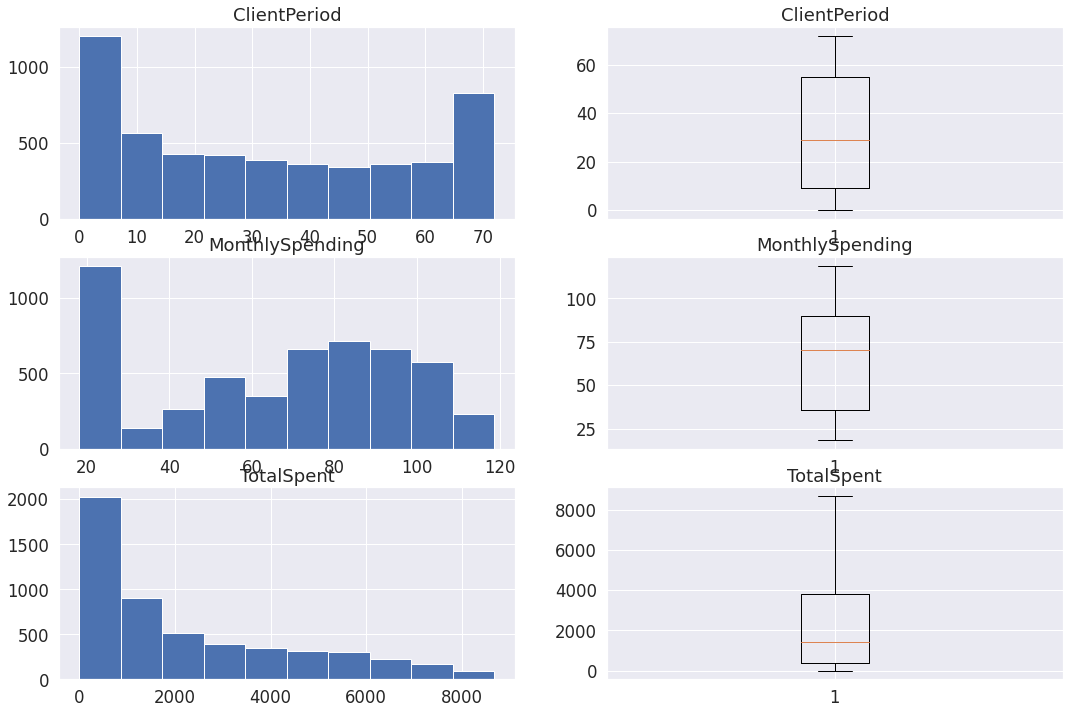

In [ ]:
# Гистограмма + boxplot для num_cols
fig, ax = plt.subplots(3 ,2 , figsize = (18,12))
for n, col in enumerate(num_cols):
  ax[n, 0].hist(x=data[col])
  ax[n, 0].set_title(col)
  ax[n, 1].boxplot(x=data[col])
  ax[n, 1].set_title(col)

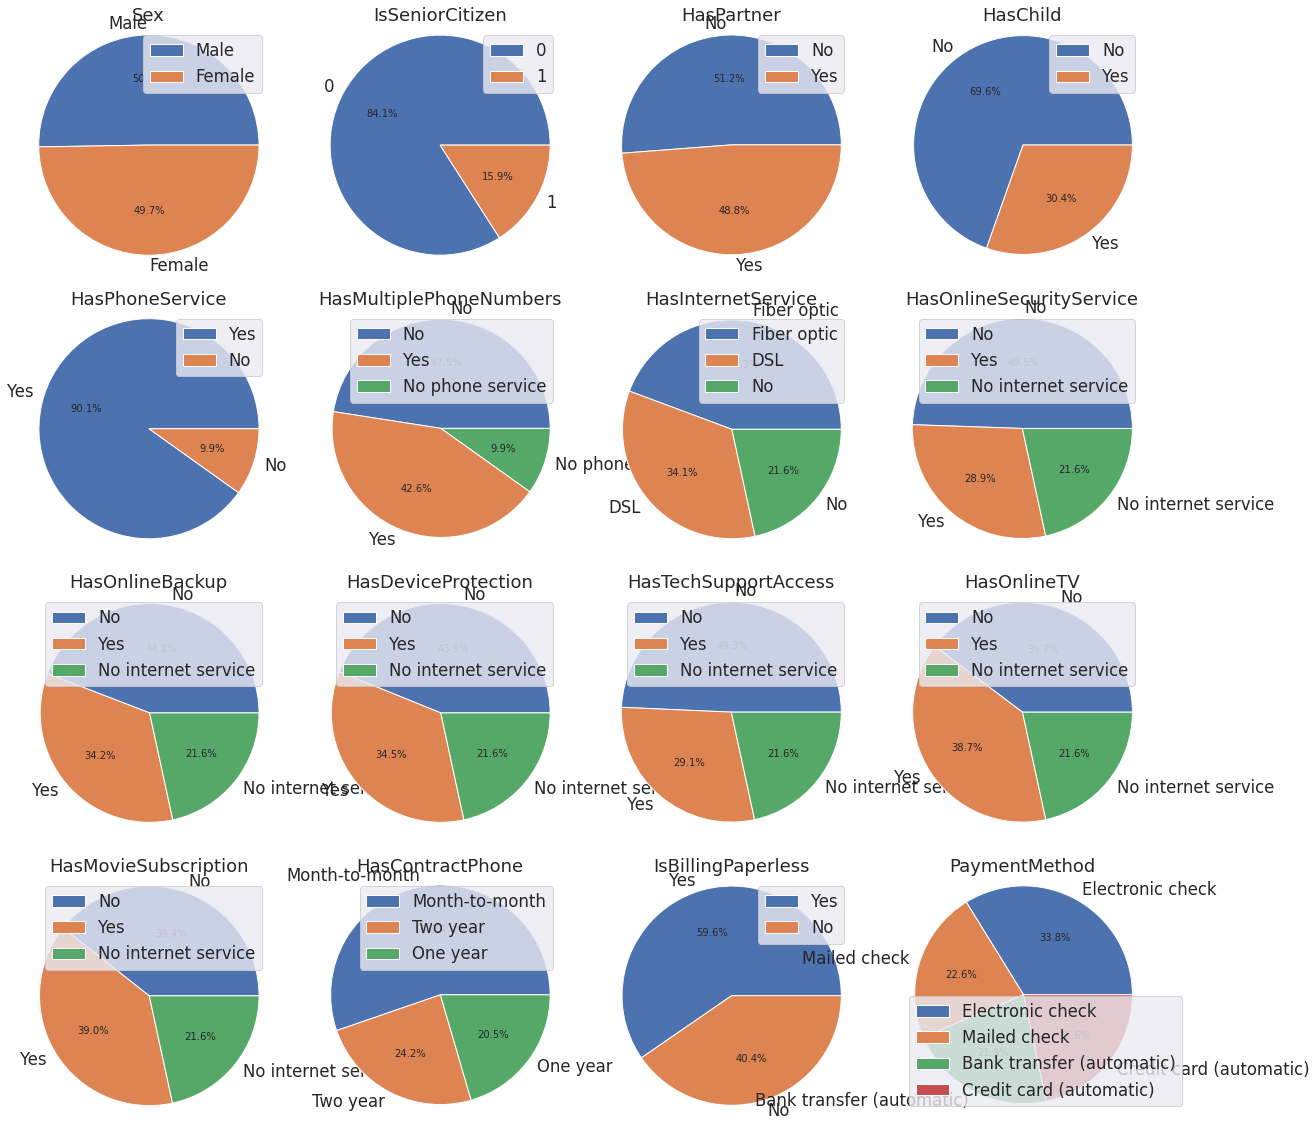

In [ ]:
# pie для cat_cols
fig = plt.figure(figsize=(20, 20))
for i in range(len(cat_cols)):
    data_col = data[cat_cols[i]].value_counts()
    plt.subplot(4, 4, i+1)
    plt.pie(data_col, labels=data_col.index, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title(cat_cols[i])
    plt.legend()

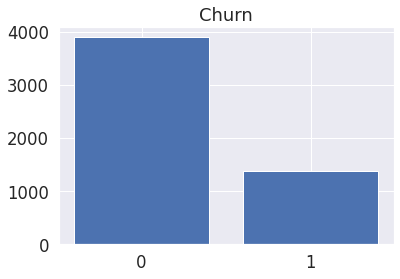

In [ ]:
# Распределение целевой переменной:
plt.bar(data[target_col].value_counts().index, data[target_col].value_counts())
plt.xticks(data[target_col].value_counts().index)
plt.title(target_col);

In [ ]:
# Соотношение между классами в tagret-переменной
data[target_col].value_counts()[0]/ data[target_col].value_counts()[1]

2.816473988439306

Наблюдем незначительный дисбаланс(соотношение классов < 4), метрику accuracy лучше не использовать

## **Предобработка**

In [ ]:
# Загрузка данных
df_train = pd.read_csv('/content/drive/MyDrive/Kaggle/Data/Предсказание оттока пользователей (весна 2021)/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Kaggle/Data/Предсказание оттока пользователей (весна 2021)/test.csv')

# Числовые и категориальные фичи
num_cols = ['ClientPeriod','MonthlySpending','TotalSpent'] 
cat_cols = ['Sex','IsSeniorCitizen','HasPartner','HasChild','HasPhoneService','HasMultiplePhoneNumbers','HasInternetService','HasOnlineSecurityService',
'HasOnlineBackup', 'HasDeviceProtection','HasTechSupportAccess','HasOnlineTV','HasMovieSubscription','HasContractPhone','IsBillingPaperless','PaymentMethod']
feature_cols = num_cols + cat_cols
target_col = 'Churn'

# Предобработка train
train = df_train.copy(deep=True)
train.TotalSpent = train.TotalSpent.replace(' ', 0).astype(float)
train.IsSeniorCitizen = train.IsSeniorCitizen.astype('str')

# Предобработка test
test = df_test.copy(deep=True)
test.TotalSpent = test.TotalSpent.replace(' ', 0).astype(float)
test.IsSeniorCitizen = test.IsSeniorCitizen.astype('str')

# print(train.isna().sum())
# print(test.isna().sum())
# print(train.info())
# print(test.info())

# Готовые данные без деления на train / test
X_train_all = train.drop([target_col], axis=1)
y_train_all = train[target_col]
X_test_all = test

# Готовые данные деленые на train / test
X_train, X_test, y_train, y_test = train_test_split(train.drop('Churn', axis = 1), train.Churn, test_size=0.2, random_state=42)

In [ ]:
def metrics_score(model, X, y):
    '''Метрики модели'''

    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:,1]
    cross_val_score_roc_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc', n_jobs=-1).mean()

    print('roc_auc_score -', metrics.roc_auc_score(y,y_pred_proba))
    print('cross_val_score(roc_auc) -', cross_val_score_roc_auc.mean())
    print('----------------------------------------------')
    print('precision_score -', metrics.precision_score(y, y_pred))
    print('recall_score -', metrics.recall_score(y, y_pred))
    print('f1_score -', metrics.f1_score(y, y_pred))
    print('----------------------------------------------')
    print('score(X,y) -', model.score(X,y))
    None

In [ ]:
def print_curve(model):
    '''Метрики модели'''

    sns.set(font_scale=1.5)
    warnings.filterwarnings("ignore")
    %matplotlib inline

    y_train_predicted = model.predict_proba(X_train)[:, 1]
    y_test_predicted = model.predict_proba(X_test)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_predicted)
    test_auc = roc_auc_score(y_test, y_test_predicted)

    plt.figure(figsize=(10,7))
    plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
    plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
    legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
    plt.show()

## **Выбор лучшей модели для обучения**

### **DecisionTreeClassifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

num_pipline = Pipeline(
    [('scaler', StandardScaler())])

cat_pipline = Pipeline(
    [('one_hot', OneHotEncoder())])

preprocessing = ColumnTransformer(
    [('num', num_pipline, num_cols),
     ('cat', cat_pipline, cat_cols)])

clf_tree = Pipeline([
          ('preprocessor', preprocessing),
          ('clf_tree', DecisionTreeClassifier(max_depth=4, random_state=42))])

clf_tree.fit(X_train,y_train)
clf_tree.score(X_test, y_test)

0.7644276253547777

In [ ]:
# метрики модели
metrics_score(clf_tree, X_test, y_test)

roc_auc_score - 0.8051458704666563
cross_val_score(roc_auc) - 0.7708044240705532
----------------------------------------------
precision_score - 0.5668202764976958
recall_score - 0.44244604316546765
f1_score - 0.49696969696969695
----------------------------------------------
score(X,y) - 0.7644276253547777


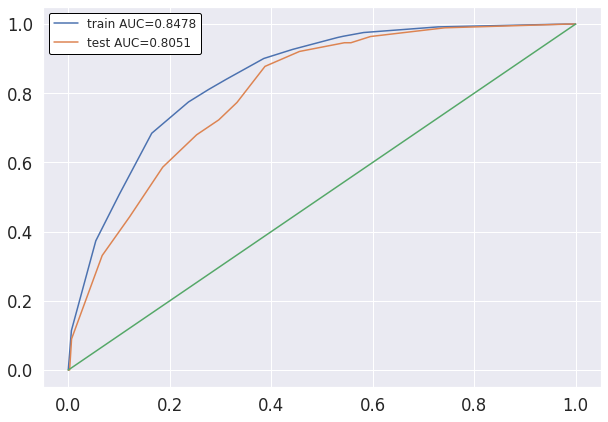

In [ ]:
# кривая ROC-AUC
print_curve(clf_tree)

### **RandomForestClassifier + GridSearchCV**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

num_pipline = Pipeline(
    [('scaler', StandardScaler())])

cat_pipline = Pipeline(
    [('one_hot', OneHotEncoder())])

preprocessing = ColumnTransformer(
    [('num', num_pipline, num_cols),
     ('cat', cat_pipline, cat_cols)])

clf_rf = Pipeline([
          ('preprocessor', preprocessing),
          ('clf', RandomForestClassifier())])

# clf_rf.get_params() названия параметров
parametrs = {'clf__n_estimators': [500], 
             'clf__max_depth': range(3,10),
             'clf__min_samples_split': range(1,5)}
clf_rf_grid = GridSearchCV(clf_rf, parametrs, n_jobs=-1, verbose = 1)
clf_rf_grid.fit(X_train, y_train)
best_clf_rf_grid = clf_rf_grid.best_estimator_
clf_rf_grid.best_params_

Fitting 5 folds for each of 28 candidates, totalling 140 fits


{'clf__max_depth': 8, 'clf__min_samples_split': 4, 'clf__n_estimators': 500}

In [ ]:
clf_rf_grid.best_score_

0.8097041420118343

In [ ]:
# метрики модели
metrics_score(best_clf_rf_grid, X_test, y_test)

roc_auc_score - 0.8244844432541258
cross_val_score(roc_auc) - 0.8095934307627856
----------------------------------------------
precision_score - 0.6402116402116402
recall_score - 0.4352517985611511
f1_score - 0.5182012847965739
----------------------------------------------
score(X,y) - 0.7871333964049196


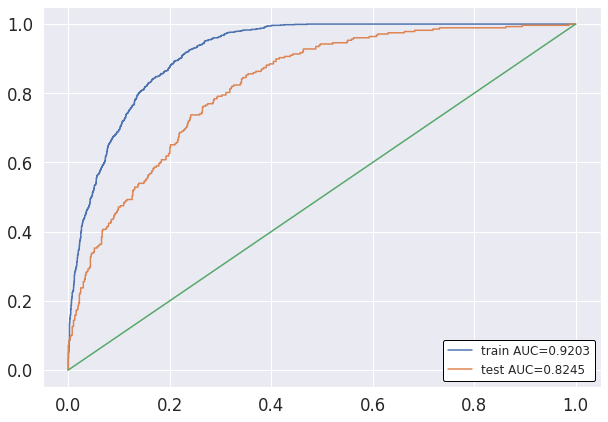

In [ ]:
# кривая ROC-AUC
print_curve(best_clf_rf_grid)



---



In [ ]:
# RandomForestClassifier + GridSearchCV для Kaggle

from sklearn.ensemble import RandomForestClassifier

num_pipline = Pipeline(
    [('scaler', StandardScaler())])

cat_pipline = Pipeline(
    [('one_hot', OneHotEncoder())])

preprocessing = ColumnTransformer(
    [('num', num_pipline, num_cols),
     ('cat', cat_pipline, cat_cols)])

clf_rf = Pipeline([
          ('preprocessor', preprocessing),
          ('clf', RandomForestClassifier())])

# clf_rf.get_params()  названия параметров
parametrs = {'clf__n_estimators': [500], 'clf__max_depth': range(7,8)}
clf_rf_grid = GridSearchCV(clf_rf, parametrs, n_jobs=-1, verbose = 1)
clf_rf_grid.fit(X_train_all, y_train_all)
best_clf_rf_grid = clf_rf_grid.best_estimator_
print(clf_rf_grid.best_params_)

submission = pd.read_csv('/content/drive/MyDrive/Kaggle/Data/Предсказание оттока пользователей (весна 2021)/submission.csv')
submission.Churn = best_clf_rf_grid.predict_proba(test)[:,1]

roc_score = cross_val_score(best_clf_rf_grid, X_train_all, y_train_all, cv=5, scoring='roc_auc', n_jobs=-1).mean()   # roc_auc_score на обученных данных
print(roc_score)
submission.to_csv(f'my_predict_{roc_score:.5f}.csv', index=False)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'clf__max_depth': 7, 'clf__n_estimators': 500}
0.8441757472698621


In [ ]:
# метрики модели
metrics_score(best_clf_rf_grid, X_train_all, y_train_all)

roc_auc_score - 0.8872614568905945
cross_val_score(roc_auc) - 0.8440602414612848
----------------------------------------------
precision_score - 0.728744939271255
recall_score - 0.5202312138728323
f1_score - 0.6070826306913996
----------------------------------------------
score(X,y) - 0.8235516849678152


### **LogisticRegressionCV**

In [ ]:
from sklearn.linear_model import LogisticRegression

num_pipline = Pipeline(
    [('scaler', StandardScaler())])

cat_pipline = Pipeline(
    [('one_hot', OneHotEncoder())])

preprocessing = ColumnTransformer(
    [('num', num_pipline, num_cols),
     ('cat', cat_pipline, cat_cols)])

clf_lr = Pipeline([
          ('preprocessor', preprocessing),
          ('clf_lr', LogisticRegressionCV(cv = 5, scoring='roc_auc', random_state=42))])

clf_lr.fit(X_train, y_train)

# метрики модели
metrics_score(clf_lr, X_test, y_test)

roc_auc_score - 0.8268486622768537
cross_val_score(roc_auc) - 0.8078423055439184
----------------------------------------------
precision_score - 0.6093023255813953
recall_score - 0.4712230215827338
f1_score - 0.5314401622718052
----------------------------------------------
score(X,y) - 0.8268486622768537


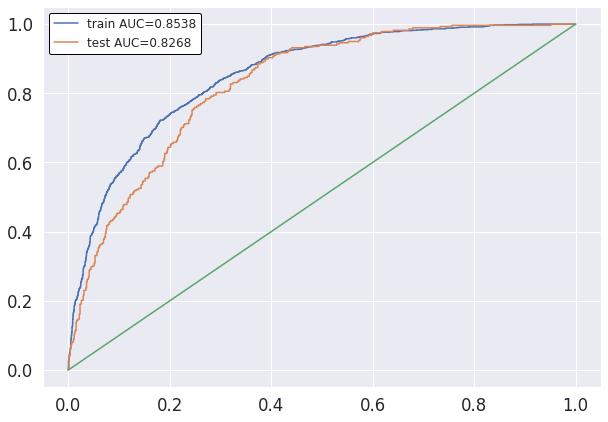

In [ ]:
# кривая ROC-AUC
print_curve(clf_lr)

### **LogisticRegression + GridSearchCV**


In [ ]:
from sklearn.linear_model import LogisticRegression

num_pipline = Pipeline(
    [('scaler', StandardScaler())])

cat_pipline = Pipeline(
    [('one_hot', OneHotEncoder())])

preprocessing = ColumnTransformer(
    [('num', num_pipline, num_cols),
     ('cat', cat_pipline, cat_cols)])

clf_lr = Pipeline([
          ('preprocessor', preprocessing),
          ('clf_lr', LogisticRegression(solver = 'liblinear', random_state=42))])

# clf_lr.get_params() названия параметров в parametrs
parametrs = {'clf_lr__C': [150, 120, 100, 50, 10, 1, 0.1, 0.01, 0.001], 
             'clf_lr__penalty': ['l1', 'l2', 'elasticnet']}

clf_lr_grid = GridSearchCV(clf_lr, 
                          parametrs, 
                          scoring='roc_auc', 
                          verbose=7,
                          n_jobs =-1)

clf_lr_grid.fit(X_train, y_train)
clf_lr_grid.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


{'clf_lr__C': 100, 'clf_lr__penalty': 'l2'}

In [ ]:
# метрики модели
metrics_score(clf_lr_grid, X_test, y_test)

roc_auc_score - 0.8268578975074112
cross_val_score(roc_auc) - 0.8123117473923926
----------------------------------------------
precision_score - 0.6111111111111112
recall_score - 0.4748201438848921
f1_score - 0.5344129554655871
----------------------------------------------
score(X,y) - 0.8268578975074112


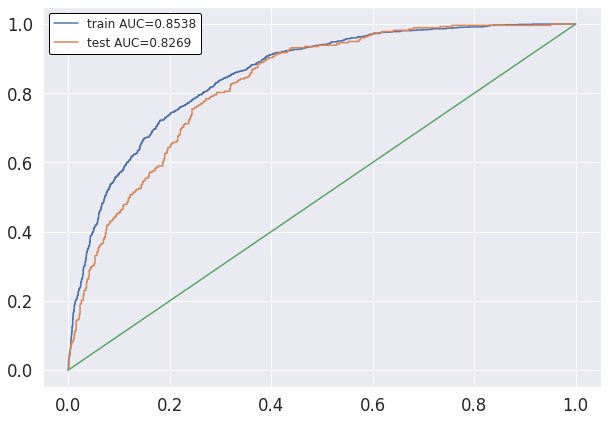

In [ ]:
# кривая ROC-AUC
print_curve(clf_lr_grid)



---



In [ ]:
# LogisticRegression + GridSearchCV для Kaggle

from sklearn.linear_model import LogisticRegression

num_pipline = Pipeline(
    [('scaler', StandardScaler())])

cat_pipline = Pipeline(
    [('one_hot', OneHotEncoder())])

preprocessing = ColumnTransformer(
    [('num', num_pipline, num_cols),
     ('cat', cat_pipline, cat_cols)])

clf_lr = Pipeline([
          ('preprocessor', preprocessing),
          ('clf_lr', LogisticRegression(penalty='l2', C=100, solver = 'liblinear', random_state=42))])

clf_lr.fit(X_train_all, y_train_all)

submission = pd.read_csv('/content/drive/MyDrive/Kaggle/Data/Предсказание оттока пользователей (весна 2021)/submission.csv')
submission.Churn = clf_lr.predict_proba(X_test_all)[:,1]

roc_score = cross_val_score(clf_lr, X_train_all, y_train_all, cv=5, scoring='roc_auc').mean()   # roc_auc_score на обученных данных
print(roc_score)
submission.to_csv(f'my_predict_{roc_score:.5f}.csv', index=False)

0.8451102074866


In [ ]:
# метрики модели
metrics_score(clf_lr, X_train_all, y_train_all)

roc_auc_score - 0.8490511845410571
cross_val_score(roc_auc) - 0.8451102074866
----------------------------------------------
precision_score - 0.6611498257839721
recall_score - 0.5484104046242775
f1_score - 0.5995260663507108
----------------------------------------------
score(X,y) - 0.8080272624006059


### **KNeighborsClassifier + GridSearchCV**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

num_pipline = Pipeline(
    [('scaler', StandardScaler())])

cat_pipline = Pipeline(
    [('one_hot', OneHotEncoder())])

preprocessing = ColumnTransformer(
    [('num', num_pipline, num_cols),
     ('cat', cat_pipline, cat_cols)])

clf_knn = Pipeline([
          ('preprocessor', preprocessing),
          ('clf', KNeighborsClassifier())])

parameters = {'clf__n_neighbors': range(1,31,10), 'clf__leaf_size':range(1,7,2)}
clf_knn_grid = GridSearchCV(clf_knn, parameters, n_jobs=-1, verbose = 1)
clf_knn_grid.fit(X_train,y_train)

print(clf_knn_grid.best_params_)
clf_knn_grid_best = clf_knn_grid.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'clf__leaf_size': 1, 'clf__n_neighbors': 21}


In [ ]:
metrics_score(clf_knn_grid_best, X_test, y_test)

roc_auc_score - 0.8097935002447336
cross_val_score(roc_auc) - 0.791647928684219
----------------------------------------------
precision_score - 0.5647058823529412
recall_score - 0.5179856115107914
f1_score - 0.5403377110694184
----------------------------------------------
score(X,y) - 0.7682119205298014


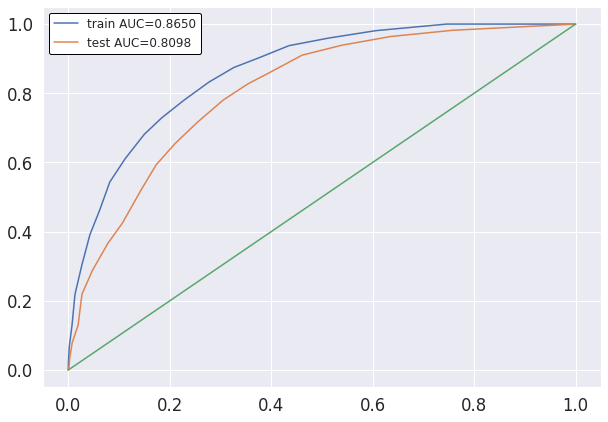

In [ ]:
# кривая ROC-AUC
print_curve(clf_knn_grid_best)

### **SGDClassifier**

In [ ]:
from sklearn.linear_model import SGDClassifier

num_pipline = Pipeline(
    [('scaler', StandardScaler())])

cat_pipline = Pipeline(
    [('one_hot', OneHotEncoder())])

preprocessing = ColumnTransformer(
    [('num', num_pipline, num_cols),
     ('cat', cat_pipline, cat_cols)])

clf_sgd = Pipeline([
          ('preprocessor', preprocessing),
          ('clf', SGDClassifier(loss = 'log'))])    # при loss = 'hinge' clf_sgd.predict_proba(X_test)[:,1] 

clf_sgd.fit(X_train, y_train)

metrics_score(clf_sgd, X_test, y_test)

roc_auc_score - 0.8230899234399387
cross_val_score(roc_auc) - 0.7825821221788963
----------------------------------------------
precision_score - 0.5725806451612904
recall_score - 0.5107913669064749
f1_score - 0.5399239543726236
----------------------------------------------
score(X,y) - 0.771050141911069


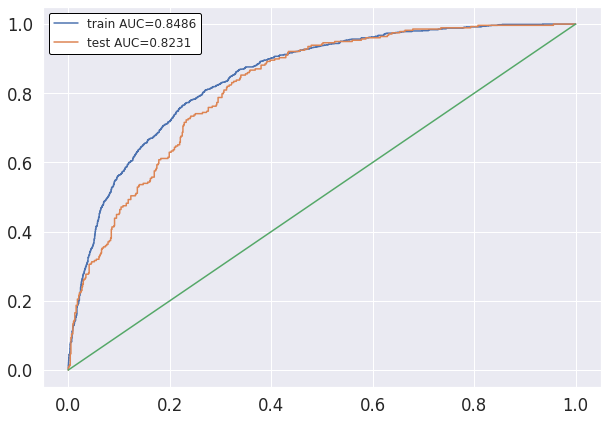

In [ ]:
# кривая ROC-AUC
print_curve(clf_sgd)

### **GaussianNB**

In [ ]:
from sklearn.naive_bayes import GaussianNB

num_pipline = Pipeline(
    [('scaler', StandardScaler())])

cat_pipline = Pipeline(
    [('one_hot', OneHotEncoder())])

preprocessing = ColumnTransformer(
    [('num', num_pipline, num_cols),
     ('cat', cat_pipline, cat_cols)])

clf_nb = Pipeline([
          ('preprocessor', preprocessing),
          ('clf', GaussianNB())])

clf_nb.fit(X_train, y_train)
clf_nb.score(X_test, y_test)

0.6830652790917692

In [ ]:
metrics_score(clf_nb, X_test, y_test)

roc_auc_score - 0.794105152335128
cross_val_score(roc_auc) - 0.7915303916513594
----------------------------------------------
precision_score - 0.4437869822485207
recall_score - 0.8093525179856115
f1_score - 0.5732484076433121
----------------------------------------------
score(X,y) - 0.6830652790917692


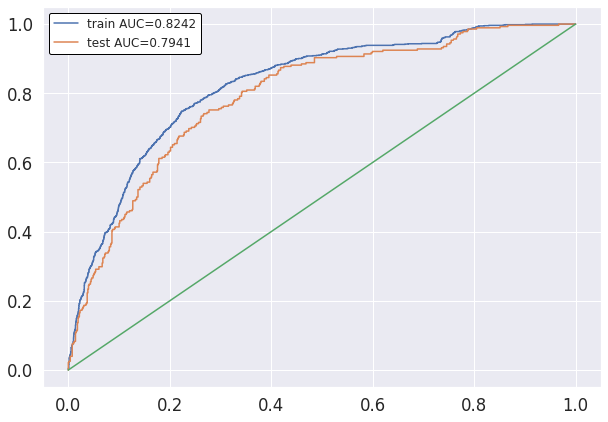

In [ ]:
# кривая ROC-AUC
print_curve(clf_nb)

In [ ]:
# кривая ROC-AUC
print_curve(clf_nb)

### **SVC (Метод Опорных Векторов) + GridSearchCV**

In [ ]:
from sklearn.svm import SVC

num_pipline = Pipeline(
    [('scaler', StandardScaler())])

cat_pipline = Pipeline(
    [('one_hot', OneHotEncoder())])

preprocessing = ColumnTransformer(
    [('num', num_pipline, num_cols),
     ('cat', cat_pipline, cat_cols)])

clf_SVC = Pipeline([
          ('preprocessor', preprocessing),
          ('SVC', SVC(probability=True))])

params = {"SVC__C": [10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005],
          # "kernel": ["linear", "rbf", "sigmoid"],
          # "gamma": ["scale", "auto"],
          "SVC__class_weight": ["balanced", None]}

clf_scv_grid = GridSearchCV(clf_SVC, params, cv=3, verbose=4, scoring='roc_auc', n_jobs=-1)
clf_scv_grid.fit(X_train, y_train)
print(clf_scv_grid.best_params_)
clf_scv_grid_best = clf_scv_grid.best_estimator_
clf_scv_grid_best.score(X_test, y_test)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.1min finished


{'SVC__C': 0.1, 'SVC__class_weight': 'balanced'}


0.7246925260170294

In [ ]:
metrics_score(clf_scv_grid_best, X_test, y_test)

roc_auc_score - 0.8182183393208412
cross_val_score(roc_auc) - 0.8054239040529364
----------------------------------------------
precision_score - 0.4852607709750567
recall_score - 0.7697841726618705
f1_score - 0.5952712100139083
----------------------------------------------
score(X,y) - 0.7246925260170294


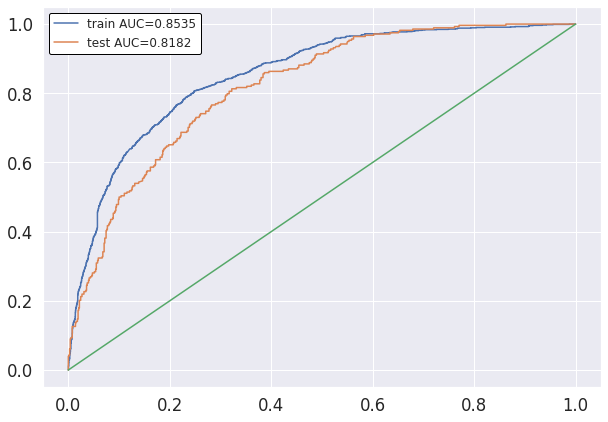

In [ ]:
# кривая ROC-AUC
print_curve(clf_scv_grid_best)

### **XGBoost + GridSearchCV**

In [ ]:
# !pip install xgboost
from xgboost import XGBClassifier

In [ ]:
num_pipline = Pipeline(
    [('scaler', StandardScaler())])

cat_pipline = Pipeline(
    [('one_hot', OneHotEncoder())])

preprocessing = ColumnTransformer(
    [('num', num_pipline, num_cols),
     ('cat', cat_pipline, cat_cols)])

clf_xgb = Pipeline([
          ('preprocessor', preprocessing),
          ('clf', XGBClassifier())])

parametrs = {'clf__max_depth': range(1,10,3),
             'clf__learning_rate': [0.001, 0.01, 0.1, 1, 10],
             'clf__n_estimators': [200, 500]}
             
clf_xgb_grid = GridSearchCV(clf_xgb, parametrs, n_jobs=-1, scoring='roc_auc', refit=True, verbose=7)
clf_xgb_grid.fit(X_train,y_train)
clf_xgb_grid_best = clf_xgb_grid.best_estimator_
clf_xgb_grid.best_params_

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  3.0min finished


{'clf__learning_rate': 0.1, 'clf__max_depth': 1, 'clf__n_estimators': 200}

In [ ]:
metrics_score(clf_xgb_grid_best, X_test, y_test)

roc_auc_score - 0.8301364043553348
cross_val_score(roc_auc) - 0.8154265626846271
----------------------------------------------
precision_score - 0.6135265700483091
recall_score - 0.4568345323741007
f1_score - 0.5237113402061856
----------------------------------------------
score(X,y) - 0.7814569536423841


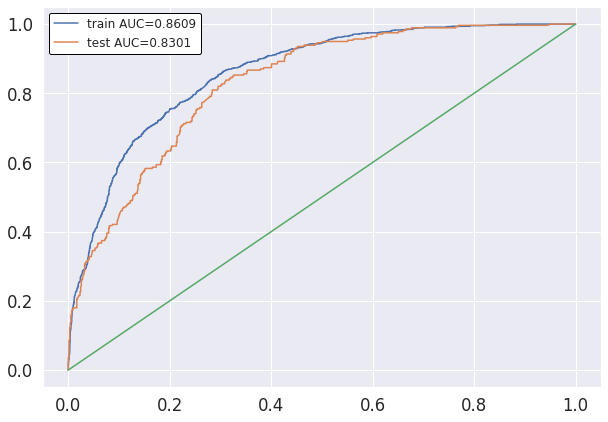

In [ ]:
# кривая ROC-AUC
print_curve(clf_xgb_grid)

### **CatBoostClassifier**

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

In [ ]:
clf_cb = CatBoostClassifier(cat_features=cat_cols, random_seed=42, verbose=False, loss_function='Logloss')
clf_cb.fit(X_train, y_train)

In [ ]:
metrics_score(clf_cb, X_test, y_test)

roc_auc_score - 0.821409111478468
cross_val_score(roc_auc) - 0.8124286197673294
----------------------------------------------
precision_score - 0.6076555023923444
recall_score - 0.4568345323741007
f1_score - 0.5215605749486653
----------------------------------------------
score(X,y) - 0.7795648060548723


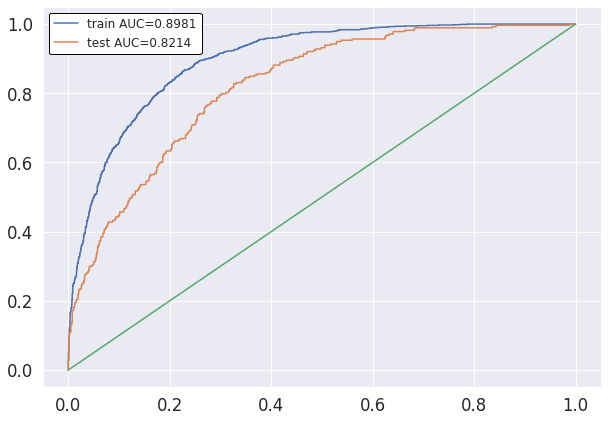

In [ ]:
# кривая ROC-AUC
print_curve(clf_cb)

In [ ]:
# Сортировка фичей по полезности
feature_importances = clf_cb.feature_importances_
feature_score = pd.DataFrame({'feature' : X_train.columns ,'score': feature_importances})
feature_score.sort_values('score', ascending=False).head(7)

,feature,score
16,HasContractPhone,15.212254
0,ClientPeriod,10.755975
2,TotalSpent,9.978155
18,PaymentMethod,9.209475
1,MonthlySpending,8.503245
9,HasInternetService,6.817273
10,HasOnlineSecurityService,6.653891


### **CatBoostClassifier + grid_search**

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

In [ ]:
# CatBoostClassifier + grid_search для Kaggle

catboost_param_grid = {"iterations": [100, 200, 300],
        "learning_rate":[0.08, 0.09 , 0.1, 0.11, 0.12, 0.13],
        "grow_policy":['Depthwise'],
        "min_data_in_leaf":[80, 90, 100, 110, 120]}
clf_cb_grid = CatBoostClassifier(cat_features=cat_cols, random_seed=42, verbose=False, loss_function='Logloss', eval_metric='AUC:hints=skip_train~false')
clf_cb_grid.grid_search(catboost_param_grid, X_train_all, y=y_train_all, plot=True)

submission = pd.read_csv('/content/drive/MyDrive/Kaggle/Data/Предсказание оттока пользователей (весна 2021)/submission.csv')
submission.Churn = clf_cb_grid.predict_proba(X_test_all)[:,1]

roc_score = cross_val_score(clf_cb_grid, X_train_all, y_train_all, cv=5, scoring='roc_auc').mean()
print(roc_score)
submission.to_csv(f'my_predict_{roc_score:.5f}.csv', index=False)
%time

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8743790363
bestIteration = 38

0:	loss: 0.8743790	best: 0.8743790 (0)	total: 1.09s	remaining: 1m 36s

bestTest = 0.8704072567
bestIteration = 20

1:	loss: 0.8704073	best: 0.8743790 (0)	total: 2.17s	remaining: 1m 35s

bestTest = 0.870899251
bestIteration = 23

2:	loss: 0.8708993	best: 0.8743790 (0)	total: 3.25s	remaining: 1m 34s

bestTest = 0.8716921739
bestIteration = 19

3:	loss: 0.8716922	best: 0.8743790 (0)	total: 4.31s	remaining: 1m 32s

bestTest = 0.8717948718
bestIteration = 29

4:	loss: 0.8717949	best: 0.8743790 (0)	total: 5.35s	remaining: 1m 30s

bestTest = 0.8733639994
bestIteration = 27

5:	loss: 0.8733640	best: 0.8743790 (0)	total: 6.41s	remaining: 1m 29s

bestTest = 0.8743790363
bestIteration = 38

6:	loss: 0.8743790	best: 0.8743790 (0)	total: 8.39s	remaining: 1m 39s

bestTest = 0.8704072567
bestIteration = 20

7:	loss: 0.8704073	best: 0.8743790 (0)	total: 10.4s	remaining: 1m 46s

bestTest = 0.870899251
bestIteration = 23

8:	loss: 0.8708993	best: 0.8743790 (0

In [ ]:
metrics_score(clf_cb_grid, X_train, y_train)

roc_auc_score - 0.8733813406369525
cross_val_score(roc_auc) - 0.8512537893937558
----------------------------------------------
precision_score - 0.7203389830508474
recall_score - 0.5379746835443038
f1_score - 0.6159420289855072
----------------------------------------------
score(X,y) - 0.8243786982248521


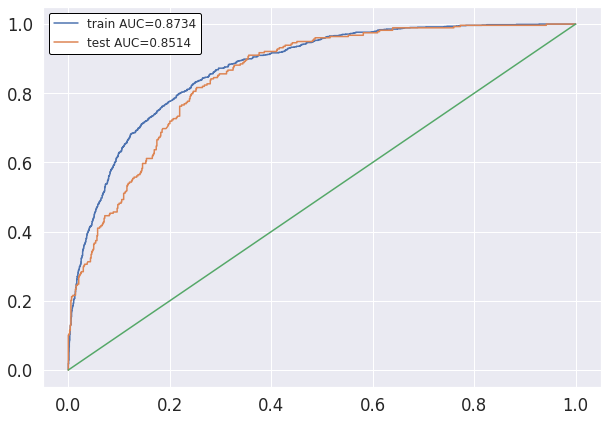

In [ ]:
print_curve(clf_cb_grid)

In [ ]:
clf_cb_grid.get_params()     # попробовать one_hot_max_size = 50

{'cat_features': ['Sex',
  'IsSeniorCitizen',
  'HasPartner',
  'HasChild',
  'HasPhoneService',
  'HasMultiplePhoneNumbers',
  'HasInternetService',
  'HasOnlineSecurityService',
  'HasOnlineBackup',
  'HasDeviceProtection',
  'HasTechSupportAccess',
  'HasOnlineTV',
  'HasMovieSubscription',
  'HasContractPhone',
  'IsBillingPaperless',
  'PaymentMethod'],
 'eval_metric': 'AUC:hints=skip_train~false',
 'grow_policy': 'Depthwise',
 'iterations': 100,
 'learning_rate': 0.11,
 'loss_function': 'Logloss',
 'min_data_in_leaf': 90,
 'random_seed': 42,
 'verbose': False}

In [ ]:
# Сортировка фичей по полезности
feature_importances = clf_cb_grid.feature_importances_
feature_score = pd.DataFrame({'feature' : X_train.columns ,'score': feature_importances})
feature_score.sort_values('score', ascending=False).head(7)

,feature,score
16,HasContractPhone,35.724338
0,ClientPeriod,12.814666
10,HasOnlineSecurityService,10.286974
9,HasInternetService,7.437735
2,TotalSpent,6.827899
1,MonthlySpending,6.391392
13,HasTechSupportAccess,5.637903




---



In [ ]:
# Kaggle - 0.85532 (5 место)

# catboost_param_grid = {"iterations": [100, 200, 300],
#         "learning_rate":[0.08, 0.09 , 0.1, 0.11, 0.12, 0.13],
#         "grow_policy":['Depthwise'],
#         "min_data_in_leaf":[80, 90, 100, 110, 120]}
# clf_cb_grid = CatBoostClassifier(cat_features=cat_cols, random_seed=42, verbose=False, loss_function='Logloss', eval_metric='AUC:hints=skip_train~false')
# clf_cb_grid.grid_search(catboost_param_grid, X_train, y=y_train)

# roc_auc_score - 0.8692604329476803
# cross_val_score - 0.8464368666671479
# Kaggle - 0.85532 (5)

# Параметры модели:
#  'eval_metric': 'AUC:hints=skip_train~false',
#  'grow_policy': 'Depthwise',
#  'iterations': 100,
#  'learning_rate': 0.11,
#  'loss_function': 'Logloss',
#  'min_data_in_leaf': 90,
#  'random_seed': 42,
#  'verbose': False}

# Сортировка фичей по полезности:
# 16	HasContractPhone	35.724338
# 0	ClientPeriod	12.814666
# 10	HasOnlineSecurityService	10.286974
# 9	HasInternetService	7.437735
# 2	TotalSpent	6.827899
# 1	MonthlySpending	6.391392
# 13	HasTechSupportAccess	5.637903



---



### **STAKING**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import StackingClassifier

from sklearn.svm import LinearSVC


num_pipline = Pipeline(
    [('scaler', StandardScaler())])

cat_pipline = Pipeline(
    [('one_hot', OneHotEncoder())])

preprocessing = ColumnTransformer(
    [('num', num_pipline, num_cols),
     ('cat', cat_pipline, cat_cols)])

estimators = [
    ('rf', make_pipeline(preprocessor,
                         RandomForestClassifier(n_estimators=500, max_depth=8))),
    ('knn', make_pipeline(preprocessor,
                          KNeighborsClassifier(n_neighbors=21, leaf_size=1))),
    ('lr' , make_pipeline(preprocessing,
                          LogisticRegression(penalty='l2', C=100, solver = 'liblinear'))),
    ('xgb', make_pipeline(preprocessing,
                          XGBClassifier( max_depth=1, learning_rate = 0.1, n_estimators = 200)))
]

final_estimator = LogisticRegression(max_iter=1000, solver="saga", C=1)

clf_stack = StackingClassifier(estimators=estimators, 
                               final_estimator=final_estimator,
                               cv=5,
                               stack_method='predict_proba')

clf_stack.fit(X_train, y_train);

In [ ]:
# метрики модели
metrics_score(clf_stack, X_test, y_test)

roc_auc_score - 0.8299747878205779
cross_val_score(roc_auc) - 0.8141219264606361
----------------------------------------------
precision_score - 0.6220095693779905
recall_score - 0.4676258992805755
f1_score - 0.5338809034907597
----------------------------------------------
score(X,y) - 0.7852412488174078


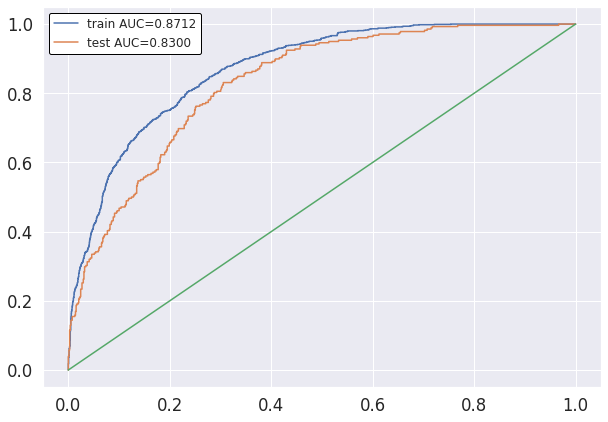

In [ ]:
print_curve(clf_stack)

## **Итоговая модель** Kaggle - 0.85532 (5 место)

In [ ]:
# Kaggle - 0.85532 (5 место)

# catboost_param_grid = {"iterations": [100, 200, 300],
#         "learning_rate":[0.08, 0.09 , 0.1, 0.11, 0.12, 0.13],
#         "grow_policy":['Depthwise'],
#         "min_data_in_leaf":[80, 90, 100, 110, 120]}
# clf_cb_grid = CatBoostClassifier(cat_features=cat_cols, random_seed=42, verbose=False, loss_function='Logloss', eval_metric='AUC:hints=skip_train~false')
# clf_cb_grid.grid_search(catboost_param_grid, X_train, y=y_train)

# roc_auc_score - 0.8692604329476803
# cross_val_score - 0.8464368666671479
# Kaggle - 0.85532 (5)

# Параметры модели:
#  'eval_metric': 'AUC:hints=skip_train~false',
#  'grow_policy': 'Depthwise',
#  'iterations': 100,
#  'learning_rate': 0.11,
#  'loss_function': 'Logloss',
#  'min_data_in_leaf': 90,
#  'random_seed': 42,
#  'verbose': False}

# Сортировка фичей по полезности:
# 16	HasContractPhone	35.724338
# 0	ClientPeriod	12.814666
# 10	HasOnlineSecurityService	10.286974
# 9	HasInternetService	7.437735
# 2	TotalSpent	6.827899
# 1	MonthlySpending	6.391392
# 13	HasTechSupportAccess	5.637903